# Pseudo-stochastic optimization model
## Imports

In [1]:
# Import packages
using MLDataUtils, CSV, DataFrames,Plots, Statistics, StatsBase
using Gurobi, JuMP
using Random 

In [738]:
# # Import data 
# df = DataFrame(CSV.read("Game_data/2022_LoL_esports_match_data_from_OraclesElixir_20221016.csv", DataFrame, pool = true))
# utility_B = DataFrame(CSV.read("Utility/U_B.csv", DataFrame, pool = true))
# utility_R = DataFrame(CSV.read("Utility/U_R.csv", DataFrame, pool = true))
# ban_vec = DataFrame(CSV.read("Utility/ban_vec.csv", DataFrame, pool = true))
# ban_mat = DataFrame(CSV.read("Utility/ban_mat.csv", DataFrame, pool = true))
# pick_mat = DataFrame(CSV.read("Utility/pick_mat.csv", DataFrame, pool = true));

## Implementation of the model
### Gurobi model

Model with only i for the bans, not implemented correctly

In [16]:
function pseudo_stochastic(df, ban_mat, pick_mat,z)

    # Define model
    model = Model(Gurobi.Optimizer)

    # Define the sets 
    n = size(utility_B)[1] # number of champions
    m = size(utility_B)[2] -1 # number of positions
    # T = 1:20 # number of events


    # Define the parameters
    epsilon = 0.001 # small number

    # Define the independant variables
    UB = Array(utility_B[:,2:end]) # blue team utility
    UR = Array(utility_R[:,2:end]) # red team utility
    
    global BU_T = 0 # total utility of blue team
    global RU_T = 0 # total utility of red team

    @variable(model, BB[1:n,1:m], Bin) # blue ban of champion i 
    @variable(model, BP[1:n,1:m], Bin) # blue pick of champion i at position j 

    @variable(model, z[1:T], Bin) # binary variable to determine if event t is a ban or a pick

    # Define the constraints
    # 1. Each champion can only be picked/banned at most once
    @constraint(model, [i=1:n], sum(BB[i] + RB[i] + BP[i,j] + RP[i,j] for j = 1:m) <= 1)

    # 2. Each team must ban at most 5 champions
    @constraint(model, sum(BB[i] for i = 1:n)  <= 5)
    @constraint(model, sum(RB[i] for i = 1:n)  <= 5)

    # 3. Each team must pick 5 champions
    @constraint(model, sum(sum(BP[i,j] for i = 1:n) for j = 1:m)  == 5)
    @constraint(model, sum(sum(RP[i,j] for i = 1:n) for j = 1:m)  == 5)

    # 4. Each team must pick 1 champion per position
    @constraint(model, [j=1:m], sum(BP[i,j] for i = 1:n) == 1)
    @constraint(model, [j=1:m], sum(RP[i,j] for i = 1:n) == 1)

    # 5. The utility of a champion picked or banned must be greater than epsilon
    @constraint(model, [i=1:n, j=1:m], UB[i,j] >= epsilon)
    @constraint(model, [i=1:n, j=1:m], UR[i,j] >= epsilon)

    # Define the objective
    @objective(model, Max, z*(sum(UB[i] * RB[i] for i = 1:n) + sum(UB[i] * RB[i,j] for i = 1:n)) + (1-z)*(sum(sum(UB[i,j] * BP[i,j] for i = 1:n) for j = 1:m) + sum(sum(UR[i,j] * RP[i,j] for i = 1:n) for j = 1:m)))


end

pseudo_stochastic (generic function with 1 method)

Model for i,j

In [211]:
function pseudo_stochastic(UB, UR, RB, RP, pool, z)

    # Define model
    model = Model(Gurobi.Optimizer)

    # Define the sets 
    n = size(UB)[1] # number of champions
    m = size(UB)[2] -1 # number of positions

    # Define the parameters
    epsilon = 0.001 # small number

    # Define the dependant variables
    @variable(model, BB[1:n,1:m], Bin) # blue ban of champion i 
    @variable(model, BP[1:n,1:m], Bin) # blue pick of champion i at position j 

    # Define the constraints
    # 1. Each champion can only be picked/banned at most once
    @constraint(model, [i=1:n], sum((BB[i,j] + RB[i,j]) + (BP[i,j] + RP[i,j]) for j = 1:m) <= 1)

    # 2. Each team must ban at most 5 champions
    @constraint(model, [j=1:m], sum(BB[i,j] for i = 1:n) <= 5)
    @constraint(model, [j=1:m], sum(RB[i,j] for i = 1:n) <= 5)

    # 3. Each team must pick 5 champions
    @constraint(model, sum(sum(BP[i,j] for i = 1:n) for j = 1:m) == 5)
    @constraint(model, sum(sum(RP[i,j] for i = 1:n) for j = 1:m) == 5)

    # 4. Each team must pick 1 champion per position
    @constraint(model, [j=1:m], sum(BP[i,j] for i = 1:n) == 1)
    @constraint(model, [j=1:m], sum(RP[i,j] for i = 1:n) == 1)

    # 5. The utility of a champion picked or banned must be greater than epsilon
    @constraint(model, [i=1:n, j=1:m], UB[i,j] >= epsilon)
    @constraint(model, [i=1:n, j=1:m], UR[i,j] >= epsilon)

    # 6. The champion picked or banned must be in the pool of champions
    @constraint(model, [i=1:n, j=1:m], BB[i,j] >= pool[i,j])
    @constraint(model, [i=1:n, j=1:m], BP[i,j] >= pool[i,j])
 
    # Define the objective
    # @objective(model, Max, z*(sum(UB[i,j] * RB[i,j] for i = 1:n) + sum(RB[i,j] * UB[i,j] for i = 1:n)) + (1-z)*(sum(sum(UB[i,j] * BP[i,j] for i = 1:n) for j = 1:m) + sum(sum(UR[i,j] * RP[i,j] for i = 1:n) for j = 1:m)))
    @objective(model, Max, z*(sum(UB[i,j] * RB for i = 1:n) + sum(RB[i,j] * UB[i,j] for i = 1:n)) + (1-z)*(sum(sum(UB[i,j] * BP[i,j] for i = 1:n) for j = 1:m) + sum(sum(UR[i,j] * RP[i,j] for i = 1:n) for j = 1:m)))

    # Solve the model
    optimize!(model)

    # Get the solution
    if JuMP.value.(z) == 1
        return JuMP.value.(BB)
    else
        return JuMP.value.(BP)
    end

end

pseudo_stochastic (generic function with 3 methods)

### Heuristic model

In [762]:
function proba_random(pool, df, type, n, pos)
    # if type is "ban"
    if type == "ban"
        # transform the dataframe by removing champion name 
        # and update the possible choices of the ban_matrix with the current pool
        df_proba = df[:,2:end] .* pool
        # find the top n champions
        top_n = sortperm(df_proba, rev=true)[1:n]
        # randomly choose one of the top n champions
        champion_row = rand(top_n)
        # retrieve the champion name
        champion_name = df[champion_row,1]
        return champion_row, champion_name
    # if type is "pick"
    elseif type == "pick"
        # transform the dataframe by removing champion name
        # and update the possible choices of the ban_matrix with the current pool
        df_proba = df[:,2:end]  .* pool
        # find the top 5 champions
        top_n = sortperm(df_proba[:,pos],rev=true )[1:n]
        # randomly choose one of the top n champions
        champion_row = rand(top_n)
        # retrieve champion position
        champion_col = pos
        # retrieve the champion name
        champion_name = df[champion_row,1] 
        return champion_row, champion_col, champion_name
    end
end

proba_random (generic function with 1 method)

In [763]:
function weighted_utility(pool, df, type, n, pos,utility)
    # if type is "ban"
    if type == "ban"
        # transform the dataframe by removing champion name 
        # and update the possible choices of the ban_matrix with the current pool
        df_proba = df[:,2:end] .* pool
        # weighted utility 
        weighted_utility = df_proba .* utility
        # find the top n champions
        top_n = sortperm(weighted_utility, rev=true)[1:n]
        # randomly choose one of the top n champions
        champion_row = rand(top_n)
        # retrieve the champion name
        champion_name = df[champion_row,1]
        return champion_row, champion_name
    # if type is "pick"
    elseif type == "pick"
        # transform the dataframe by removing champion name
        # and update the possible choices of the ban_matrix with the current pool
        df_proba = df[:,2:end]  .* pool
        # weighted utility 
        weighted_utility = df_proba .* utility
        # find the top 5 champions
        top_n = sortperm(weighted_utility[:,pos],rev=true )[1:n]
        # randomly choose one of the top n champions
        champion_row = rand(top_n)
        # retrieve champion position
        champion_col = pos
        # retrieve the champion name
        champion_name = df[champion_row,1] 
        return champion_row, champion_col, champion_name
    end
end

weighted_utility (generic function with 1 method)

In [722]:
function optimal_choice(pool, utility, type, pos)

    # transform the dataframe by removing champion name 
    # and update the possible choices of the ban_matrix with the current pool
    utility = utility .* pool

    # if type is "ban"
    if type == "ban"
        # find the top n champions
        opt = findmax(utility)
        # best utility
        u_opt = opt[1]
        # retrieve the champion row
        champion_row = opt[2][1]
        # retrieve the champion col
        champion_col = opt[2][2]
        return u_opt, champion_row, champion_col
    # if type is "pick"
    elseif type == "pick"
        # find the top n champions
        opt = findmax(utility[:,pos])
        # best utility
        u_opt = opt[1]
        # retrieve the champion row
        champion_row = opt[2][1]
        # retrieve the champion col
        champion_col = pos
        return u_opt, champion_row, champion_col
    end
end

optimal_choice (generic function with 2 methods)

we can add one more function that determines a similar top 5 but instead does it with utility which are weighted based on the probabilities

In [740]:
# Dataframe for bans
bans = DataFrame(Ban1 = String[], Ban2 = String[], Ban3 = String[], Ban4 = String[], Ban5 = String[]) # matrix of champions banned to understand order of choices
push!(bans, [" ", " ", " ", " ", " "])
push!(bans, [" ", " ", " ", " ", " "])
# Dataframe for picks
picks = DataFrame(Pick1 = String[], Pick2 = String[], Pick3 = String[], Pick4 = String[], Pick5 = String[]) # matrix of champions picked to understand order of choices
push!(picks, [" ", " ", " ", " ", " "])
push!(picks, [" ", " ", " ", " ", " "])
push!(picks, [" ", " ", " ", " ", " "])
push!(picks, [" ", " ", " ", " ", " "])

# Define the sets
tbb = [1,3,5,14,16] # blue team ban events
trb = [2,4,6,13,15] # red team ban events
tbp = [7,10,11,18,19] # blue team pick events
trp = [8,9,12,17,20]; # red team pick events

In [764]:
function baseline(r,model)
    # Define decision variables
    T = 20 # number of events
    n = size(utility_B)[1] # number of champions
    m = size(utility_B)[2] -1; # number of positions
    global pool = ones(n,m) # matrix of champions in the pool

    # Probability matrices
    ban_proba = ban_mat[:,2:end]
    pick_proba = pick_mat[:,2:end]

    # Event vectors for picks
    picks_red = [1,2,3,4,5]
    picks_blue = [1,2,3,4,5]

    global banned = []
    # Set dummy variables
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0

    # Define the independant variables
    UB = Array(utility_B[:,2:end]) # blue team utility
    UR = Array(utility_R[:,2:end]) # red team utility

    # Total utility
    BU_T = 0 # total utility of blue team
    RU_T = 0; # total utility of red team

    for t in 1:T
        if t in tbb
            t1 += 1
            # find champion with highest utility
            fun = optimal_choice(pool,UR,"ban",0)
            # retrieve the champion row
            blue_ban = fun[2]
            # push blue_ban to banned list
            push!(banned, blue_ban)
            # calculate utility of the red ban
            BU_T += fun[1]
            # update the pool
            pool[blue_ban,:] .= 0
            # add the red ban to the bans matrix row 2
            bans[1,t1] = ban_mat[blue_ban,1]
        
        elseif t in trb
            t2 += 1
            # choose randomly the red ban from the top-5 most probable champions
            if model == "random"
                fun = proba_random(pool,ban_mat,"ban",r,0)
            elseif model == "weighted"
                fun = weighted_utility(pool,ban_mat,"ban",r,0,UB)
            end
            # fun = top_n_random(pool, ban_mat, "ban", r,0)
            # fun = weighted_utility(pool, ban_mat, "ban", r,0, UB)
            red_ban = fun[1]
            # push red_ban to banned list
            push!(banned, red_ban)
            # calculate utility of the red ban
            RU_T += maximum(UB[red_ban, :])
            # update the pool
            pool[red_ban,:] .= 0
            # add the red ban to the bans matrix row 2
            bans[2,t2] = fun[2]


        elseif t in tbp
            t3 += 1
            # best possible pick
            opt_pick_utility = 0 
            blue_pick = 0
            pos = 0 
            # picks available
            picks_available = picks_blue[picks_blue .> 0]
            for i in picks_available 
                fun = optimal_choice(pool,UB,"pick",i)
                if fun[1] > opt_pick_utility
                    opt_pick_utility = fun[1]
                    # champion row
                    blue_pick = fun[2]
                    # champion position
                    pos = fun[3]
                end
            end
            # push blue_pick to banned list
            push!(banned, blue_pick)
            # calculate utility of the blue pick
            BU_T += opt_pick_utility
            # update the pool
            pool[blue_pick,:] .= 0
            # add the red pick to the pick matrix row 1
            picks[1,t3] = pick_mat[blue_pick,1]
            # add the position of the pick in row 2
            picks[2,t3] = names(pick_mat)[pos+1]
            # remove the position from the picks_blue vector
            picks_blue[pos] = 0


        elseif t in trp
            t4 += 1
            # picks available
            picks_available = picks_red[picks_red .> 0]
            # randomly choose a number from picks_available (i.e. the position of the pick)
            pos = rand(picks_available)
            # run function
            if model == "random"
                fun = proba_random(pool,pick_mat,"pick",r,pos)
            elseif model == "weighted"
                fun = weighted_utility(pool,pick_mat,"pick",r,pos,UR)
            end
            # fun = top_n_random(pool, pick_mat, "pick", r, pos)
            # fun = weighted_utility(pool, pick_mat, "pick", r,pos, UR)
            # choose randomly the pick from the top-5 most probable champions at that position 
            red_pick = fun[1]
            # push red_pick to banned list
            push!(banned, red_pick)
            # calculate utility of the red ban
            RU_T += UR[red_pick, pos]
            # update the pool
            pool[red_pick,:] .= 0
            # add the red pick to the picks matrix row 3
            picks[3,t4] = fun[3]
            # add the position of the pick in row 4
            picks[4,t4] = names(pick_mat)[pos+1]
            # remove the position from the picks_played vector
            picks_red[pos] = 0

        else 
            println("Error")
        end 
    end
    return BU_T, RU_T, bans, picks
end

baseline (generic function with 2 methods)

### Results for top-3 champions in a purely probabilistic model

In [773]:
BU_T, RU_T, bans, picks = baseline(3,"random");

In [774]:
# which elements appear more than once in the banned list
unique([x for x in banned if count(isequal(x), banned) > 1])

Any[]

In [775]:
picks

Row,Pick1,Pick2,Pick3,Pick4,Pick5
,String,String,String,String,String
1,Nautilus,Xin Zhao,Gwen,Vex,Jhin
2,sup,jng,top,mid,bot
3,Ezreal,Lissandra,Nami,Jax,Wukong
4,bot,mid,sup,top,jng


In [776]:
bans

Row,Ban1,Ban2,Ban3,Ban4,Ban5
,String,String,String,String,String
1,Aphelios,Viego,Jinx,Ahri,Ornn
2,Kalista,Zeri,Lucian,Draven,Xayah


In [777]:
BU_T

37.51115583147018

In [778]:
RU_T

21.501682707274394

In [779]:
# number of 1 in pool
sum(pool[:,1] .== 0)

20

### Results for top-3 champions in a weighted probabilistic model

In [787]:
BU_T, RU_T, bans, picks = baseline(3,"weighted");

In [788]:
# which elements appear more than once in the banned list
unique([x for x in banned if count(isequal(x), banned) > 1])

Any[]

In [789]:
picks

Row,Pick1,Pick2,Pick3,Pick4,Pick5
,String,String,String,String,String
1,Nautilus,Xin Zhao,Gwen,Vex,Ezreal
2,sup,jng,top,mid,bot
3,Corki,Lee Sin,Sivir,Tahm Kench,Gangplank
4,mid,jng,bot,sup,top


In [790]:
bans

Row,Ban1,Ban2,Ban3,Ban4,Ban5
,String,String,String,String,String
1,Aphelios,Viego,Ahri,Ornn,Wukong
2,Zeri,Jinx,Kalista,Seraphine,Draven


In [791]:
BU_T

37.3798298720367

In [792]:
RU_T

26.840893497475694

In [793]:
# number of 1 in pool
sum(pool[:,1] .== 0)

20

### Plotting the probabilistic model

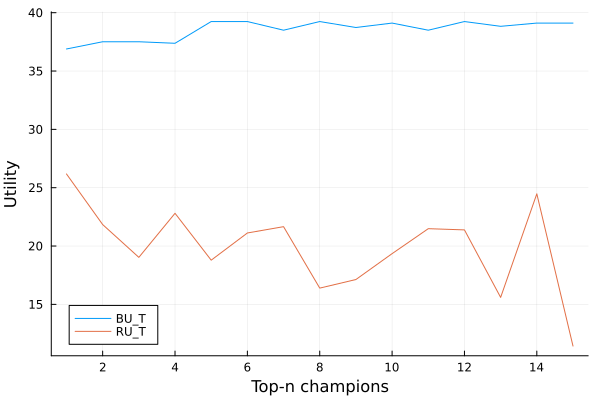

In [795]:
# plot BU_T and RU_T for different values of r
r = 1:15
BU_T = zeros(15)
RU_T = zeros(15)
for i in r
    BU_T[i], RU_T[i], bans, picks = baseline(i,"random")
end
plot(r, BU_T, label = "BU_T")
plot!(r, RU_T, label = "RU_T")
# legend on bottom left 
plot!(legend = :bottomleft)
# y axis label as "Utility"
plot!(ylabel = "Utility")
# x axis label as "r"
plot!(xlabel = "Top-n champions")


### Plotting the weighted probabilistic model

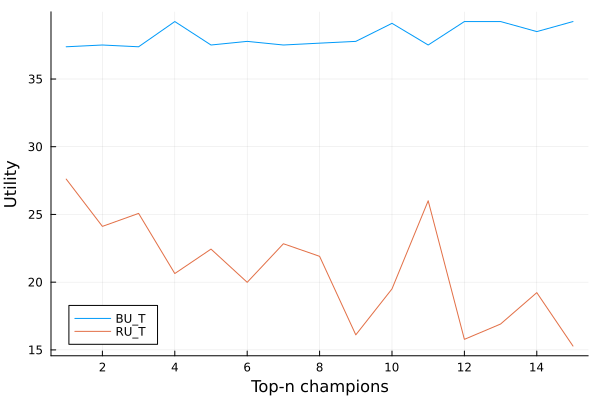

In [796]:
# plot BU_T and RU_T for different values of r
r = 1:15
BU_T = zeros(15)
RU_T = zeros(15)
for i in r
    BU_T[i], RU_T[i], bans, picks = baseline(i,"weighted")
end
plot(r, BU_T, label = "BU_T")
plot!(r, RU_T, label = "RU_T")
# legend on bottom left 
plot!(legend = :bottomleft)
# y axis label as "Utility"
plot!(ylabel = "Utility")
# x axis label as "r"
plot!(xlabel = "Top-n champions")


### Plot both on same plot

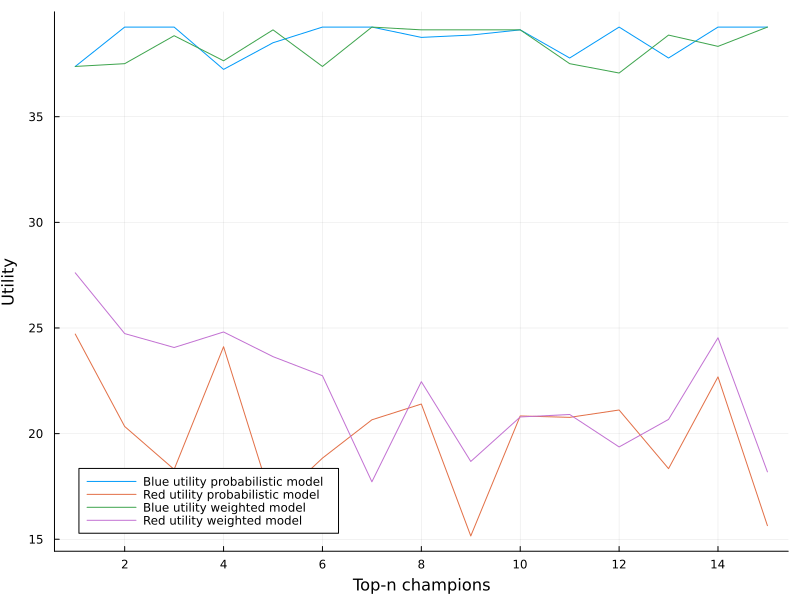

In [801]:
# plot BU_T and RU_T for different values of r and for both models
r = 1:15
BU_T = zeros(15)
RU_T = zeros(15)
BU_T2 = zeros(15)
RU_T2 = zeros(15)
for i in r
    BU_T[i], RU_T[i], bans, picks = baseline(i,"random")
    BU_T2[i], RU_T2[i], bans, picks = baseline(i,"weighted")
end

plot(r, BU_T, label = "Blue utility probabilistic model")
plot!(r, RU_T, label = "Red utility probabilistic model")
plot!(r, BU_T2, label = "Blue utility weighted model")
plot!(r, RU_T2, label = "Red utility weighted model")

# legend on bottom left
plot!(legend = :bottomleft)

# y axis label as "Utility"
plot!(ylabel = "Utility")

# x axis label as "r"
plot!(xlabel = "Top-n champions")

# increase size of plot 
plot!(size = (800, 600))

# increase line width
plot!(linewidth = 10)



In [564]:
# function optimal_choice(pool, utility, type, pos, banned)

#     # transform the dataframe by removing champion name 
#     # and update the possible choices of the ban_matrix with the current pool
#     utility = utility .* pool
#     # sort the indices of bans
#     banned = sort(banned, rev = true)
#     # usable values of utility
#     util_usable = utility[setdiff(1:size(utility,1), sort(utility, rev = true)),:]
    
#     # if type is "ban"
#     if type == "ban"
#         # find the top n champions
#         opt = findmax(util_usable)
#         # best utility
#         u_opt = util_usable
#         # retrieve the champion row
#         champion_row = findall(x->x==maximum(utility), utility)[1]
#         # retrieve the champion col
#         champion_col = findall(x->x==maximum(utility), utility)[2]
#         return u_opt, champion_row, champion_col
#     # if type is "pick"
#     elseif type == "pick"
#         # find the top n champions
#         opt = findmax(utility[:,pos])
#         # best utility
#         u_opt = opt[1]
#         # retrieve the champion row
#         champion_row = opt[2][1]
#         # retrieve the champion col
#         champion_col = pos
#         return u_opt, champion_row, champion_col
#     end
# end

optimal_choice (generic function with 2 methods)

In [ ]:
# function top_n_random(pool, df, type, n, pos)

#     # transform the dataframe by removing champion name 
#     # and update the possible choices of the ban_matrix with the current pool
#     df_proba = df[:,2:end] .* pool
#     # sort the indices of bans
#     banned = sort(banned, rev = true)
#     # usable values of utility
#     p_usable = df_proba[setdiff(1:size(df_proba,1), sort(df_proba, rev = true)),:]    

#     # if type is "ban"
#     if type == "ban"
#         # find the top n champions
#         top_n = sortperm(p_usable, rev=true)[1:n]
#         # randomly choose one of the top n champions
#         champion_choice = rand(top_n)
#         # find position 
#         pos = findmax(Array(p_usable[champion_choice,:]))[2]
#         # retrieve row in original dataset
#         champion_row = findall(x->x==maximum(p_usable[champion_row,:]), df_proba[:,pos])
#         # retrieve the champion name
#         champion_name = df[champion_row,1]
#         return champion_row, champion_name
#     # if type is "pick"
#     elseif type == "pick"
#         # find the top 5 champions
#         top_n = sortperm(pick_proba[:,pos],rev=true )[1:n]
#         # randomly choose one of the top n champions
#         champion_row = rand(top_n)
#         # retrieve champion position
#         champion_col = pos
#         # retrieve the champion name
#         champion_name = df[champion_row,1] 
#         return champion_row, champion_col, champion_name
#     end
# end